In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as nnf
import pandas as pd
import requests
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import random
import string

CTX_LENGTH = 32
BLOCK_LENGTH = 350
BLOCK_COUNT = 1000

In [2]:
# URL of the dataset CSV
csv_url = 'https://huggingface.co/datasets/readerbench/ro-stories/resolve/main/ro_paragraphs_12516.csv'

# Download the CSV file
response = requests.get(csv_url)
csv_content = response.content.decode('utf-8')

# Save the CSV content to a file (optional)
with open('ro_stories.csv', 'w', encoding='utf-8') as file:
    file.write(csv_content)

# Read the CSV file into a DataFrame
df = pd.read_csv('ro_stories.csv')

In [3]:
class LetterTokenizer:
    def __init__(self, txt):
        self.letters = list(set(''.join(txt)))
        self.vocab_size = len(self.letters)
        self.token_to_id = {char: idx for idx, char in enumerate(self.letters)}
        self.id_to_token = {idx: char for idx, char in enumerate(self.letters)}
        self.pad_token_id = self.token_to_id[" "]  # Using space as pad token

    def encode(self, text):
        text = text.lower()  # Convert text to lowercase for caseless operation
        return [self.token_to_id[char] for char in text if char in self.token_to_id]

    def decode(self, token_ids):
        return "".join([self.id_to_token[token_id] for token_id in token_ids])

#tokenizer = AutoTokenizer.from_pretrained("readerbench/RoBERT-base")
tokenizer = LetterTokenizer(df.paragraph.to_list())
print("Vocabulary size " + str(tokenizer.vocab_size))

paragraphs = df.paragraph.apply(lambda x: tokenizer.encode(x)).to_list()

Vocabulary size 201


(array([1.190e+02, 1.660e+02, 1.310e+02, 1.400e+02, 1.380e+02, 1.590e+02,
        4.920e+02, 4.416e+03, 4.679e+03, 1.523e+03, 3.700e+02, 1.200e+02,
        4.400e+01, 8.000e+00, 6.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([2.00000e+00, 1.51650e+02, 3.01300e+02, 4.50950e+02, 6.00600e+02,
        7.50250e+02, 8.99900e+02, 1.04955e+03, 1.19920e+03, 1.34885e+03,
        1.49850e+03, 1.64815e+03, 1.79780e+03, 1.94745e+03, 2.09710e+03,
        2.24675e+03, 2.39640e+03, 2.54605e+03, 2.69570e+03, 2.84535e+03,
        2.99500e+03]),
 <BarContainer object of 20 artists>)

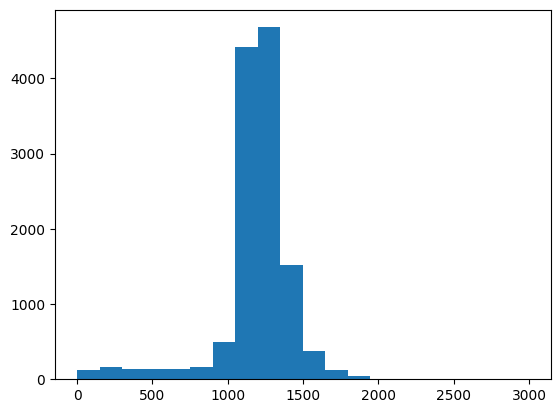

In [4]:
lens = [len(x) for x in paragraphs]
plt.hist(lens, bins=20)

In [5]:
def uniformize_length(paragraph, length, rev = False):
  if len(paragraph) > length:
    # Truncate the paragraph if it is longer than the desired length
    return paragraph[:length] if rev == False else paragraph[-length:]
  else:
    # Pad the paragraph with tokenizer.pad_token_id if it is shorter than the desired length
    return (paragraph + [tokenizer.pad_token_id] * (length - len(paragraph))) if rev == False else ([tokenizer.pad_token_id] * (length - len(paragraph)) + paragraph)

In [6]:
class RnnModel(nn.Module):
  def __init__(self, ctx, n_neurons):
    super().__init__()
    self.ctx = ctx
    self.l1 = torch.nn.Linear(ctx * tokenizer.vocab_size, n_neurons)
    self.activation = torch.nn.SELU()
    self.softmax = torch.nn.LogSoftmax()
    self.l2 = torch.nn.Linear(n_neurons, n_neurons)
    self.l3 = torch.nn.Linear(n_neurons, tokenizer.vocab_size)

  def forward(self, x):
    x = self.activation(self.l1(x))
    #x = self.l2(x)
    x = self.l3(x)
    return x

In [7]:
model = RnnModel(CTX_LENGTH, 500)
criterion = nn.CrossEntropyLoss()

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU
losses = []
model.to(device)

RnnModel(
  (l1): Linear(in_features=6432, out_features=500, bias=True)
  (activation): SELU()
  (softmax): LogSoftmax(dim=None)
  (l2): Linear(in_features=500, out_features=500, bias=True)
  (l3): Linear(in_features=500, out_features=201, bias=True)
)

Linear(in_features=6432, out_features=500, bias=True)
Training for n_steps=100
Step 1, Current loss: 2.8334, Average Loss: 2.8334441493297446
Step 2, Current loss: 3.1242, Average Loss: 2.978840513569434
Step 3, Current loss: 2.7359, Average Loss: 2.8978469415393615
Step 4, Current loss: 2.7848, Average Loss: 2.86957635298418
Step 5, Current loss: 2.6067, Average Loss: 2.8170099125573627
Step 6, Current loss: 2.8561, Average Loss: 2.8235220477654512
Step 7, Current loss: 2.6448, Average Loss: 2.7979972246872484
Step 8, Current loss: 3.0003, Average Loss: 2.823284585055162
Step 9, Current loss: 2.5524, Average Loss: 2.793183557896799
Step 10, Current loss: 2.9550, Average Loss: 2.809366800654738
Step 11, Current loss: 2.7693, Average Loss: 2.8057215881864885
Step 12, Current loss: 1.9129, Average Loss: 2.7313219648681044
Step 13, Current loss: 2.6083, Average Loss: 2.72185619751765
Step 14, Current loss: 2.8719, Average Loss: 2.73257016785757
Step 15, Current loss: 2.5844, Average Loss:

KeyboardInterrupt: 

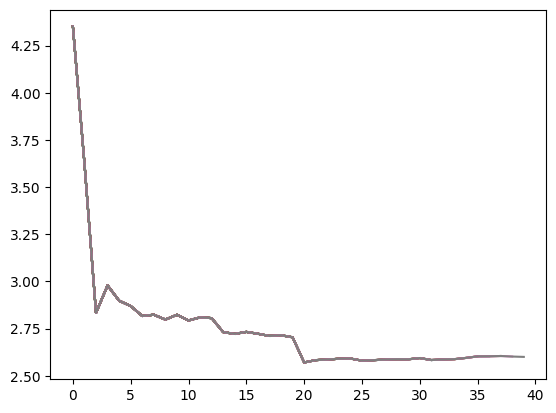

In [9]:
LEARNING_RATE = 1e-3

optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
dataset = [uniformize_length(x, BLOCK_LENGTH + 1) for x in random.sample(paragraphs, BLOCK_COUNT)]
inputs = torch.tensor(dataset)

n_steps = 100
print(model.l1)
print("Training for n_steps=" + str(n_steps))
avg_loss = 0
for step in range(n_steps):
    input_t = inputs[step]

    model.train()
    batch_loss = 0
    for i in range(model.ctx, input_t.shape[0] - model.ctx):
      model.zero_grad()
      input_block = input_t[i:i + model.ctx]
      target_block = input_t[i + model.ctx]

      # One-hot encoded input
      input_block = nnf.one_hot(input_block, num_classes=tokenizer.vocab_size).float().to(device)
      input_block = input_block.view(1, -1)[0]

      target_block = nnf.one_hot(target_block, num_classes=tokenizer.vocab_size).float().to(device)

      # Forward pass
      output = model(input_block)

      loss = criterion(output, target_block)

      # Backward pass
      loss.backward()
      optimizer.step()

      batch_loss += loss.item()

    avg_loss += batch_loss / (input_t.shape[0] - model.ctx)
    losses.append(avg_loss / (step + 1))
    plt.plot(losses)
    print(f"Step {step+1}, Current loss: {(batch_loss / (input_t.shape[0] - model.ctx)):.4f}, Average Loss: {avg_loss / (step + 1)}")

plt.plot(losses)

In [14]:
gen = torch.Generator(device=device).manual_seed(int(random.random() * 1000000))

def predict_tokens(prompt, length):
    model.eval()  # Set model to evaluation mode

    # Tokenize the prompt
    prompt_tokens = tokenizer.encode(prompt)[:-1]

    # Predict tokens
    for _ in range(length):
        # Prepare the input: last CTX_LENGTH tokens from the prompt
        input_tokens = uniformize_length(prompt_tokens, model.ctx, rev=True)
        input_t = nnf.one_hot(torch.tensor(input_tokens), num_classes=tokenizer.vocab_size).float().to(device)
        input_t = input_t.view(1, -1)[0]

        # Get model output
        with torch.no_grad():
            output = model(input_t)

        # Get the token with the highest probability
        next_token = torch.multinomial(nnf.softmax(output, dim=0), num_samples=1, replacement=True, generator=gen).item()
        prompt_tokens.append(next_token)

    # Decode the tokens to string
    completion = tokenizer.decode(prompt_tokens)
    return completion

# Example usage
prompt = "Amu cică ar fi putut"
completion = predict_tokens(prompt, 100)
print(completion + ".")

amu cică ar fi putuă eiei deainoul l retșuni emcânre fe oripce,ci arrna săranlezum și rideput celenijrecas,relaarânruga.
